# Perfilado (Profiling) de rutinas de Python

El primer paso antes de optimizar es identificar los sectores críticos o "cuellos de botella" de nuestro programa. A esto lo llamamos hacer un perfilado (*profiling*) del código.

## ¿Qué es *profiling*?

Se refiere a medir 

1. Tiempo de ejecución, ya sea total, por función o por línea de código.
1. Utilización de recursos de hardware como memoria, cpu o disco duro.

de una rutina con el fin de encontrar aquellas secciones más lentas e ineficientes (sectores críticos). A continuación veremos como hacer *profiling* de nuestro código en Python utilizando las magias de *IPython*.

A modo de ejemplo haremos *profiling* de un script de Python que calcula el famoso fractal conocido como el [Conjunto de Julia](https://es.wikipedia.org/wiki/Conjunto_de_Julia) (Julia Set), llamado así en honor a su descubridor, el matemático francés Gaston Maurice Julia.

El fractal de Julia corresponde a todos los números complejos $z$ para los que la siguiente ecuación

$$
f(z) = z^2 + c,
$$

no diverge al ser calculada recursivamente. En la ecuación anterior $c \in \mathbb{C}$.

El *script* [fractal.py](./fractal.py) tiene una implementación del conjunto de Julia usando Python puro, es decir sin usar librerias. La implementación se muestra a continuación:

In [1]:
from IPython.display import Code
Code(filename="src/fractal.py")

def evaluate_z(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi**2
    zr2 = zr**2
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit
    
def make_fractal(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate_z(zi, zr, maxiters))
        image.append(row)
    return image

Si ejecutamos la función `make_fractal` con una resolución de 500 pixeles y 50 iteraciones el resultado es

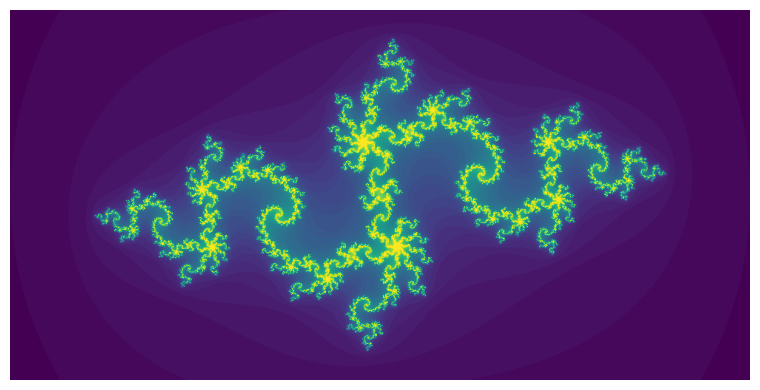

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from src.fractal import make_fractal, evaluate_z

fractal_image = make_fractal(N=500, maxiters=50)

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.imshow(fractal_image, aspect='equal', origin='lower')
ax.axis('off');

A continuación realizaremos un *profiling* del tiempo computacional necesario para calcular el fractal.

## Midiendo tiempo de ejecución

### Magia `%time`

Python tiene un módulo nativo llamado [`timeit`](https://docs.python.org/3/library/timeit.html#module-timeit) que ofrece funciones para medir tiempo de cómputo. Algunas de estas funciones han sido incorporadas en magias de IPython, lo cual permite utilizarlas de forma simple y conveniente.

La primera que revisaremos es [`%time`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) que se usa anteponiendose a una función como muestra el ejemplo.

```python
%time mi_resultado = mi_funcion(mis_argumentos)
```

El resultado de la línea anterior es algo similar a:

```
CPU times: user 2.44 s, sys: 2.41 ms, total: 2.45 s
Wall time: 2.57 s
```

donde

- *Wall time*: Es el tiempo total de un proceso/función/expresión desde que se lanza hasta que retorna.
- *CPU time (total)*: Es el tiempo que el CPU dedica a procesar la tarea solicitada, siempre será menor que el *Wall-time*.

:::{note}

La magia `%time` mide el tiempo de una línea de código. Si queremos medir el tiempo total de un bloque de ejecución de Jupyter completo podemos agregar  `%%time` al principio del bloque.

:::


**Ejemplos**

Midamos el tiempo que demora en calcularse el fractal de Julia con la magia `%time`

In [3]:
%time result1 = make_fractal(N=500, maxiters=50)

CPU times: user 2.11 s, sys: 1.13 ms, total: 2.11 s
Wall time: 2.12 s


¿Qué ocurre si medimos una segunda vez?

In [4]:
%time result2 = make_fractal(N=500, maxiters=50)

CPU times: user 2.08 s, sys: 10.8 ms, total: 2.1 s
Wall time: 2.11 s


In [5]:
np.allclose(result1, result2)

True

:::{note}

El resultado en ambos casos es idéntico, sin embargo, el tiempo de ejecución son ligeramente distintos.

:::

:::{warning}

Cada vez que ejecutamos un código alteramos el estado de nuestro sistema (cache, memoria). Por lo tanto lo más correcto para medir el tiempo de nuestra rutina es ejecutarla varias veces y calcular un promedio.

:::

### Magía `%timeit` 

Podemos obtener estadísticos del tiempo de cómputo de un script, función o expresión de Python de forma conveniente usando la magia [`timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

Esta magia tiene varios argumentos, a continuación revisamos los más importantes:

- `-r<R>`: Define que el algoritmo se repetira `<R>` veces para calcular los estadísticos
- `-n<N>`: Define que el algoritmo se ejecutará `<N>` veces seguidas (loop) en cada repetición
- `-p<P>`: Se usa una precisión de `<P>` dígitos en los resultados
- `-q`: No imprimir los resultados
- `-o`: Retorna un objeto `TimeitResult`, con el cual podemos manipular, analizar y graficar los tiempos de ejecución


Esta magia se utiliza como 

```python
 %timeit -r10 -n5 mi_funcion(mis_argumentos)
```

Que en pseudo código sería como

```python
tiempos = []
for _ in range(10): # Repeticiones (<R>=10)
    t_inicio = time.now() 
    for _ in range(5): # Loop (<N>=5)
        mi_funcion(mis_argumentos)
    t_fin = time.now()
    tiempos.append(t_fin - t_inicio)
    
return sum(tiempos)/(N*R) 
```

Es decir que `timeit` retorna un promedio de promedios. En general:

- `<R>` debe ser lo suficientemente grande para que los estadísticos que calculemos sean confiables
- `<N>` debe ser lo suficientemente grande para que el tiempo medido sea representativo de `mi_funcion`


:::{warning}

Si `mi_funcion` toma menos de 10 microsegundos es recomendable subir el $N$. De lo contrario el tiempo podría estar dominado por otros procesos, como por ejemplo el `garbage collector` de Python.

:::

:::{note}

Si no se especifica `<N>` la magia buscará de forma automática un valor adecuado.

:::

**Ejemplo**

Utilicemos `timeit` para hacer profiling de `make_fractal`

In [6]:
time_object = %timeit -r3 -n3 -o -q make_fractal(N=500, maxiters=50)
time_object

<TimeitResult : 2.12 s ± 43.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)>

Los atributos más importantes del objeto `TimeitResult` son:

- `timings`: Lista con los tiempos de cada repetición 
- `average`: Promedio de los tiempos
- `stdev`: Desviación estándar de los tiempos
- `best` y `worst`: Tiempo más rápido y más lento, respectivamente


In [7]:
time_object.average, time_object.stdev, time_object.best, time_object.worst

(2.122926094888903,
 0.043487481422218886,
 2.076626405000146,
 2.1811329733333573)

In [8]:
np.array(time_object.timings)

array([2.18113297, 2.11101891, 2.07662641])

### Magia `%prun`

El módulo nativo de Python [cProfile](https://docs.python.org/3/library/profile.html) mide la cantidad de llamadas y el tiempo de cada función ejecutada por nuestra rutina.

La magia de IPython [`%prun`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun) nos da una forma conveniente para usar este módulo

```python
%prun mi_funcion()
```

Lo anterior retorna  una tabla con las siguientes filas:

- ncalls: Número de veces que se llama la función
- tottime: Tiempo total en dicha función (sin contar subfunciones)
- percall: ttime/ncalls
- cumtime: Tiempo total en dicha función y sus subfunciones (tiempo de función recursiva)
- percall: cumtime/ncalls

Algunos argumentos importantes de `%prun`:

- `-s` para que el resultado quede ordenado según una fila en particular 
- `-l` si queremos especificar la cantidad de líneas a mostrar en la tabla

**Visualizando el resultado de `prun`**

Podemos generar una visualización de los resultados de `cProfile` en nuestro navegador usando [`SnakeViz`](https://jiffyclub.github.io/snakeviz/). Puedes instalar la librería usando el siguiente comando de conda.

    conda install snakeviz
    
Esto creará un ejecutable `snakeviz`. Antes de utilizar en jupyter es necesario habilitar la magia cargando la extensión, como se muestra a continuación:

```python
%load_ext snakeviz
%snakeviz -t make_fractal(N=500, maxiters=50)
```

lo cual retorna un resultado gráfico similar al siguiente

<img src="img/snakeviz.png" width="900">

:::{note}

La opción `-t` carga el gráfico en una pestaña de navegador nueva.

:::

Esta herramienta puede mejorar considerablemente el estudio de nuestro código cuando se tiene una gran cantidad de funciones en distintas jerarquías.

**`cProfile` sin IPython**

Si no contamos con el ambiente IPython podemos usar cProfile directamente sobre un script de Python con

        python -m cProfile -o tabla.prof script.py
        
Donde el resultado queda grabado en el archivo tabla.prof

### Magia  `%lprun`

Hemos visto como medir el tiempo total de un código en Python y el tiempo desglosado por cada llamado a función de dicho código. Pero en ocasiones puede resultar más informativo estudiar el tiempo de ejecución de cada linea de nuestro código por separado.

:::{note}

Esto corresponde a un tipo de *profiling* llamado *line by line*.

:::

Podemos hacer este tipo de profiling usando la extensión externa [`line_profiler`](https://github.com/pyutils/line_profiler). 

Una vez instalada se debe cargar la extensión para habilitar la magia `lprun`, como se muestra a continuación:

**Ejemplo**

```python
%load_ext line_profiler
%lprun -f mi_método mi_rutina
```

Esta magia requiere que se especifique un método o función dentro de la rutina con el argumento `-f`. Ejecutar la magia levantará una pestaña con una tabla.

La tabla tiene una fila por linea de código y las siguientes columnas:

- Line: Número de la linea dentro del código fuente
- Hits: La cantidad de veces que se llama a esa linea
- Time: Tiempo total de dicha linea
- Per hit: Tiempo total dividido la cantidad de llamadas
- %Time: Porcentaje del tiempo de dicha linea con respecto al tiempo total del método


## Medir uso de memoria

### Magia `%memit`

Podemos medir la memoria utilizada por un proceso usando la librería externa [`memory_profiler`](https://github.com/pythonprofilers/memory_profiler). Se puede instalar facilmente con:

    conda install memory_profiler

Luego se habilita y utiliza con

```python
%load_ext memory_profiler
%memit funcion()
```

Que retorna la cantidad de memoria RAM usada por `funcion`

:::{note}

Con esto también se habilita la magia `%mprun` para medir el uso de memoria linea a linea

:::

### Módulo `tracemalloc`

Python tiene un módulo nativo llamado [`tracemalloc`](https://docs.python.org/3/library/tracemalloc.html) que permite calcular estadísticas sobre la memoria reservada por un proceso o script de Python

A continuación se muestra un ejemplo de uso

```python
import tracemalloc

tracemalloc.start()

# Acá se corre el código que quieres estudiar

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

```
